# Part 1

In [2]:
# dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

# dataset was exported as csv and converted to spreadsheet... now opening spreadsheet
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1fe8ekNzQ6D30nSxvfQSFrm2_7bBt6qAXr6k1C09hM-g/edit#gid=1100966621').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# convert to a DataFrame
df = pd.DataFrame.from_records(rows)
df_features = pd.DataFrame.from_records(rows)
worksheet

<Worksheet 'healthcare-dataset-stroke-data' id:1100966621>

In [3]:
(df.iloc[0])[7] = 'residence_type'

# using first row to rename columns
df.columns = df.iloc[0]

# now that first row has been used to rename columns we don't need the first row anymore so we can get rid of it
df.drop(index = 0, inplace = True)

# getting mean of a column with missing values
temp_df = df[df.bmi != 'N/A']
temp_df['bmi'] = temp_df['bmi'].astype('float64')
mean = temp_df['bmi'].mean()
mean = round(mean, 1)
# imputing mean
df['bmi'] = df['bmi'].replace('N/A', mean)

# snippet below assigns 'id' as index but I want to keep number of columns as 12
# df = df.set_index(df.columns[0])

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
3,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [4]:
# ordinal encoding will be used for visualization (kind of a hacky solution)

dfv = df

cat_cols = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
for col in cat_cols:
  A = (dfv[col].unique()).tolist()
  B = range(len(A))
  dfv[col].replace(A, B, inplace=True)

# converting dtype of all columns for visualization

for col in dfv:
  dfv[col] = dfv[col].astype('float64')

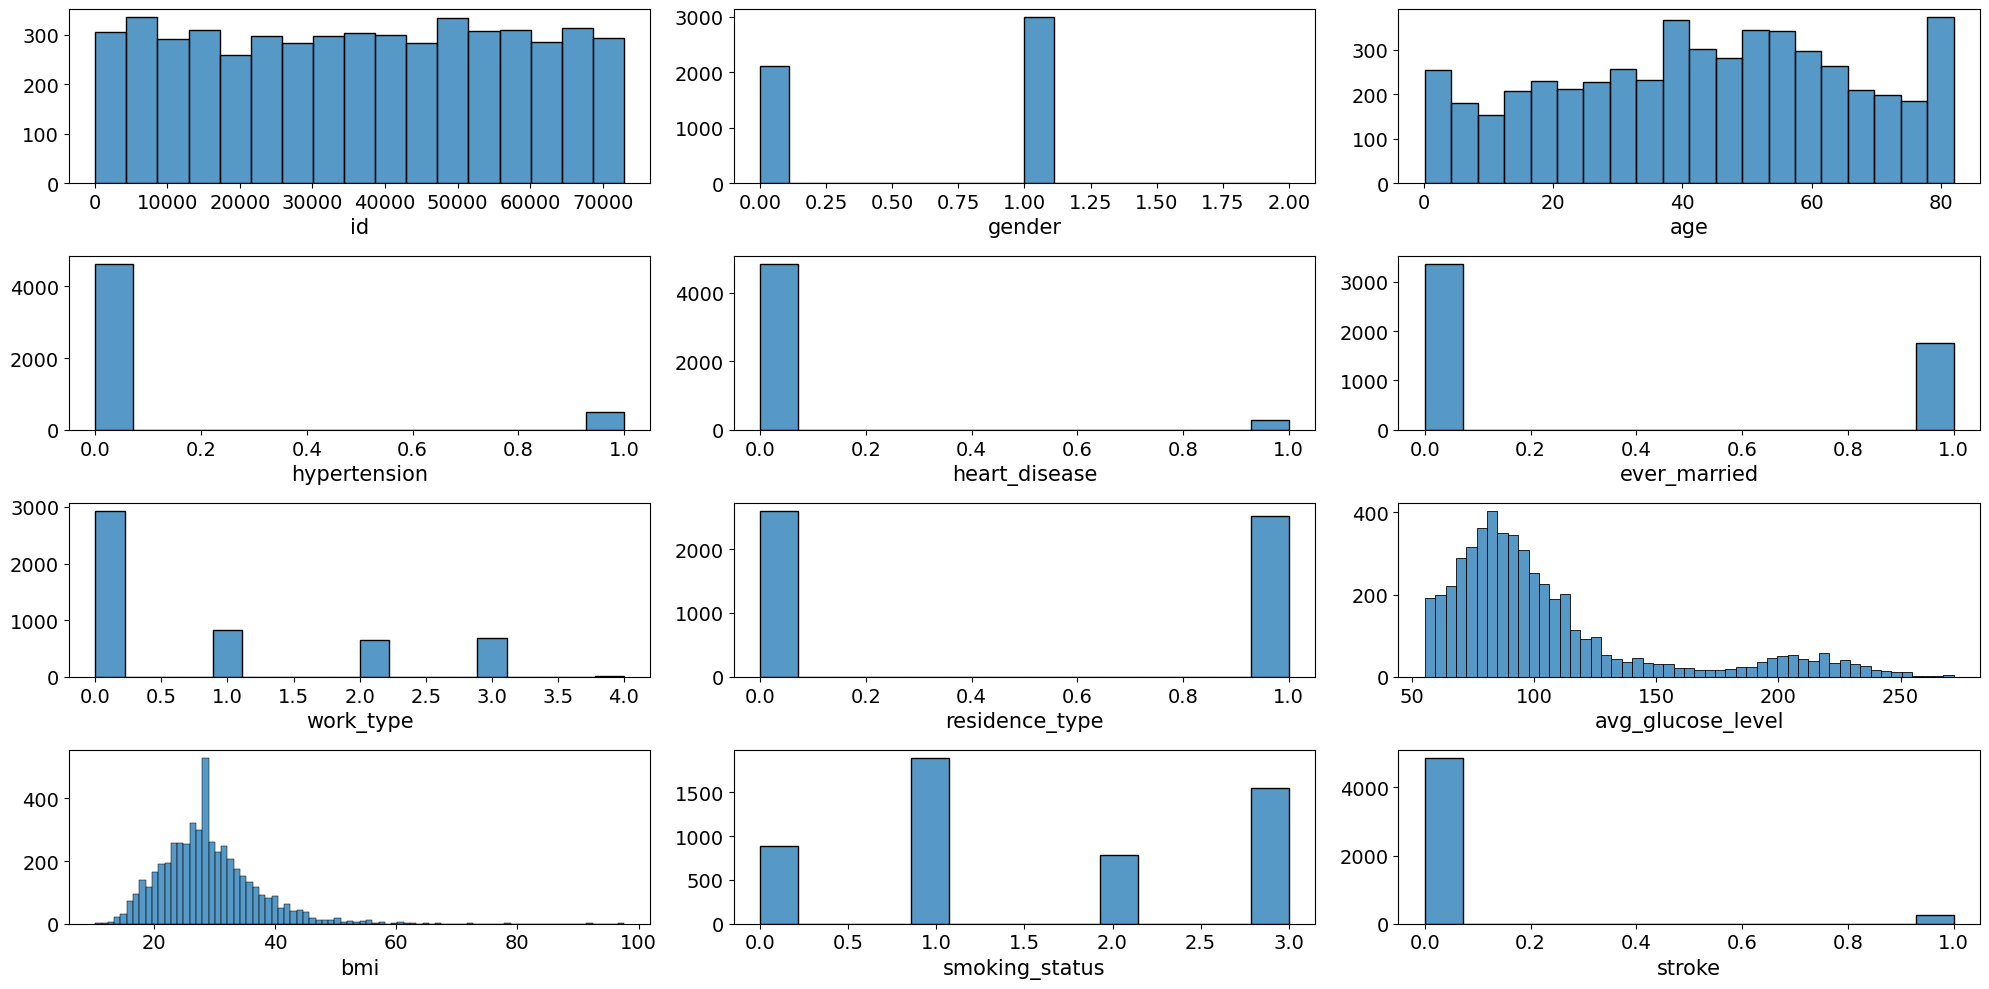

In [5]:
# create dist plot
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(20, 10))
index = 0
ax = ax.flatten()
for col, value in dfv.items():
    g1=sns.histplot(value, ax=ax[index])
    g1.set(ylabel=None)
    ax[index].xaxis.label.set_size(15)
    ax[index].tick_params(axis="x", labelsize=14)
    ax[index].tick_params(axis="y", labelsize=14)
    index += 1
plt.tight_layout()

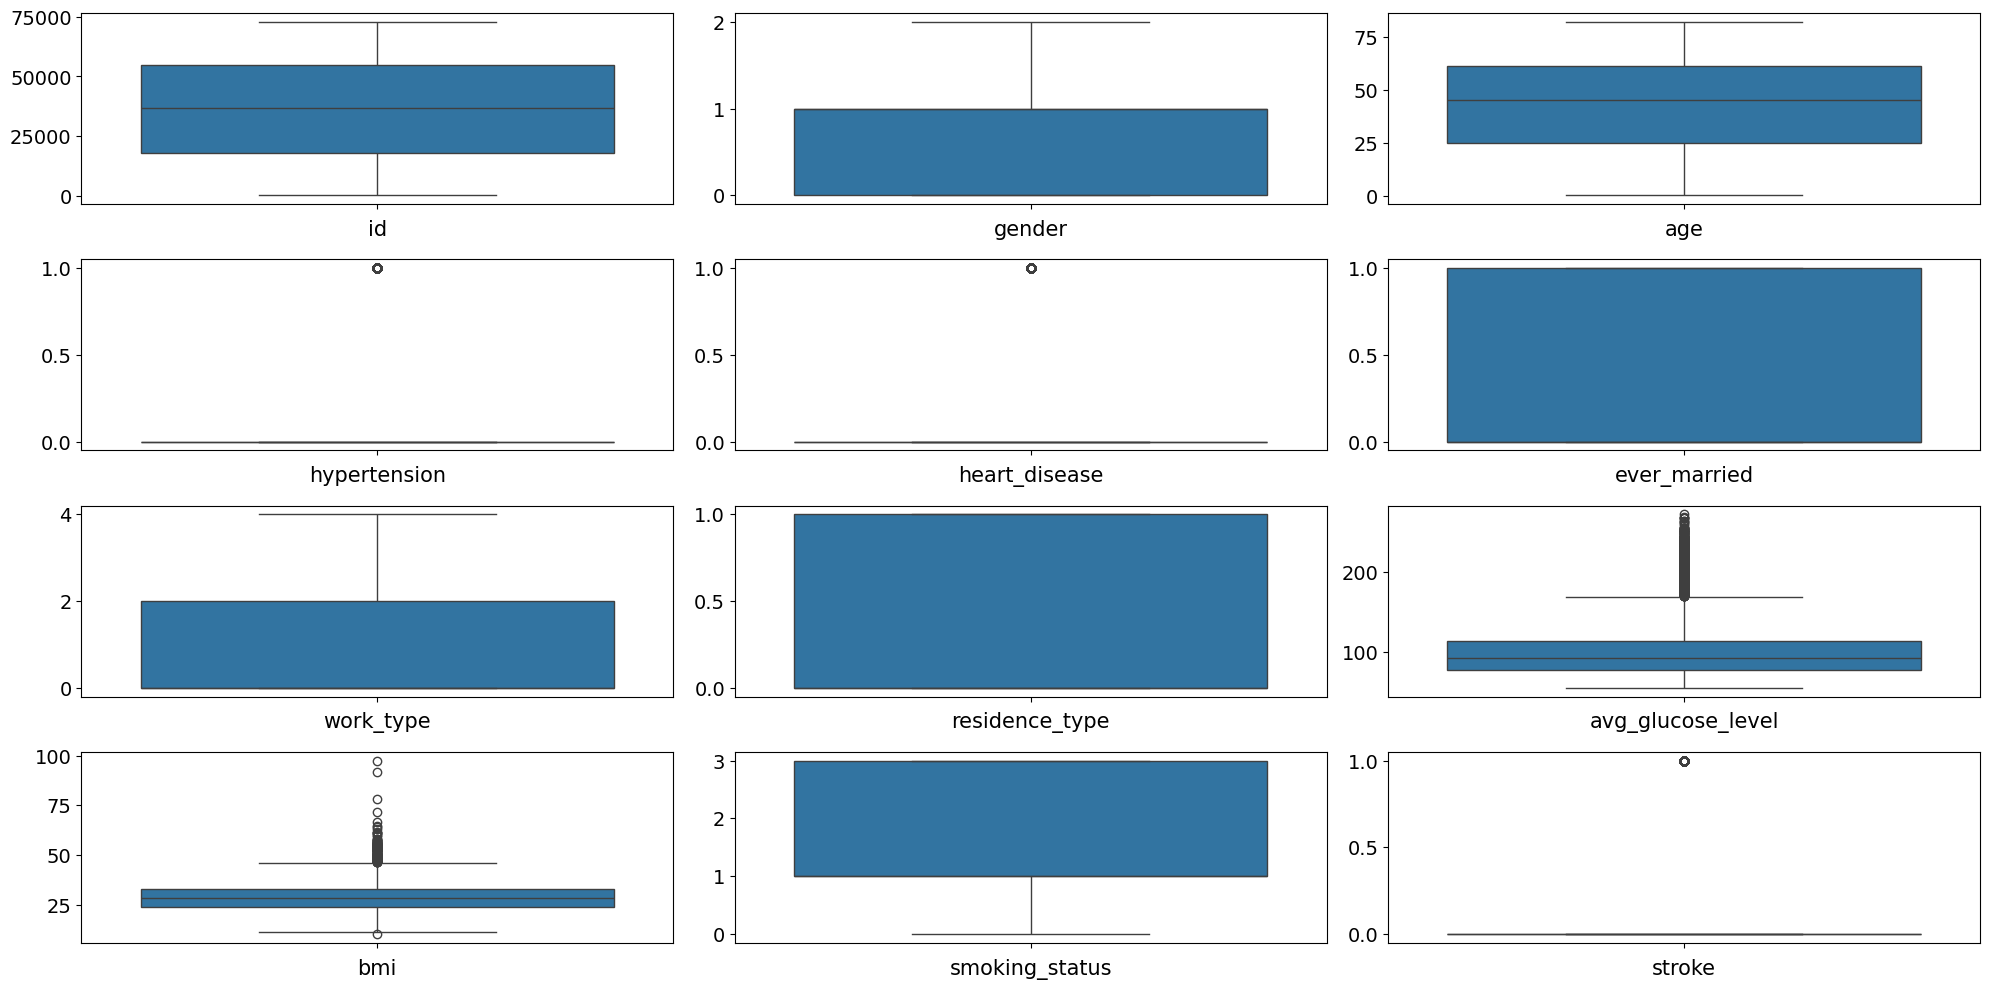

In [6]:
# create box plots
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(20, 10))
index = 0
ax = ax.flatten()
for col, value in dfv.items():
    sns.boxplot(y=col, data=dfv, ax=ax[index])
    ax[index].set(xlabel=col,ylabel='',title='')
    ax[index].xaxis.label.set_size(15)
    ax[index].tick_params(axis="x", labelsize=14)
    ax[index].tick_params(axis="y", labelsize=14)
    index += 1
plt.tight_layout()

In [8]:
import matplotlib.colors as clr
myColors = ("red","white","blue")
cmap1 = clr.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
corr = dfv.corr()
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(20,10))
sns.heatmap(corr,mask = mask, vmin = -1, vmax = 1, annot=True)

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

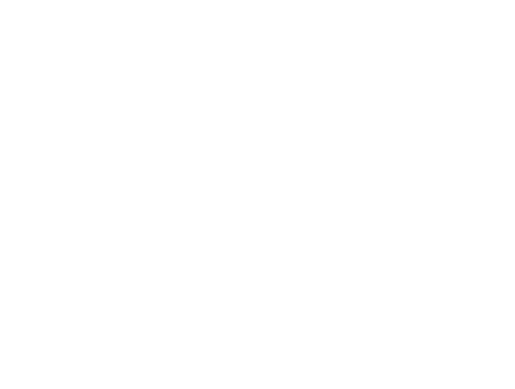

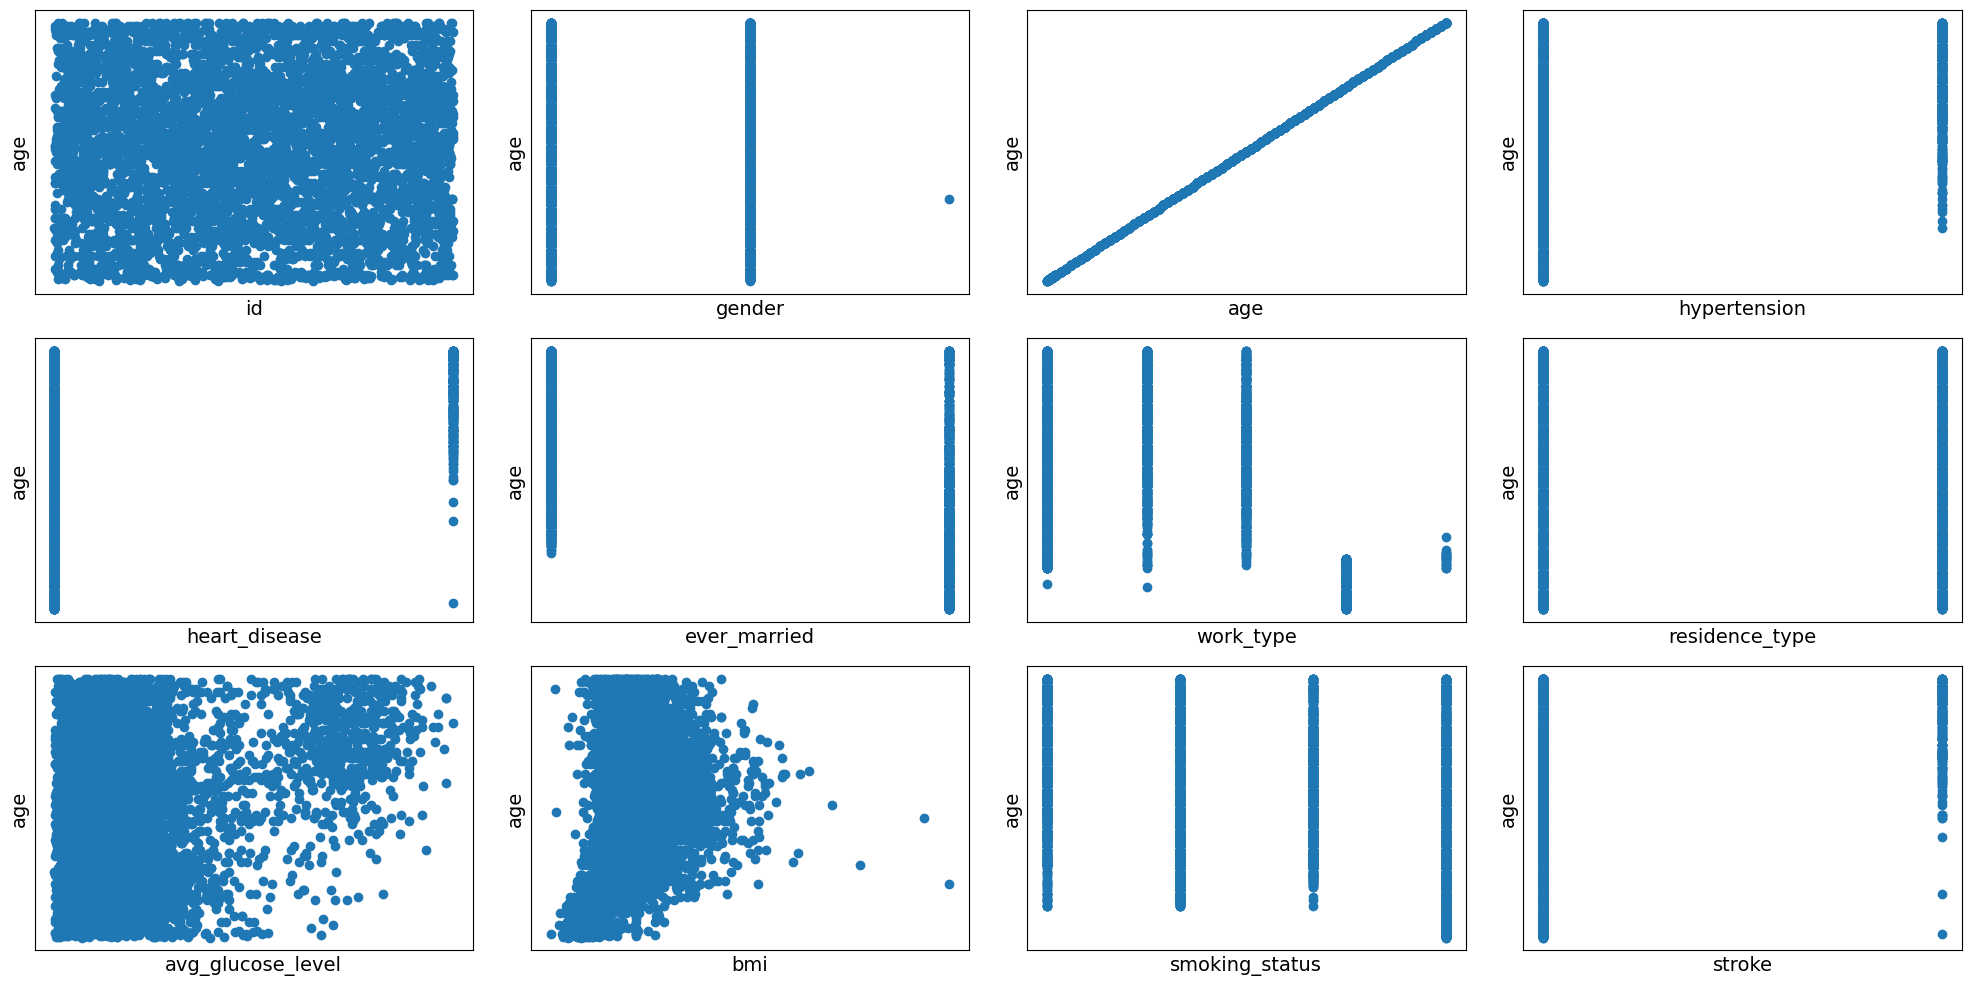

In [9]:
num_cols = (dfv.columns).tolist()
plt.axis('off')
fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(20,10))
fig.tight_layout()
count=0
for row in ax:
    for col in row:
        if(count<len(num_cols)):
          col.set_xlabel(num_cols[count], fontsize=14)
          # setting target var as ylabel but target can be any column name
          col.set_ylabel("age", fontsize=14)
          col.set_xticks([])
          col.set_yticks([])
          # setting target var as target but any column can be used as column
          col.plot(df[num_cols[count]], df["age"],"o")
        count+=1
plt.show()

# Part 2

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_cols = ['avg_glucose_level','bmi']
categorical_cols = ['gender','hypertension','heart_disease','ever_married','work_type','residence_type','smoking_status','stroke']

# preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [12]:
# splitting data
feats = (df.columns).tolist()
filt_feats = feats
filt_feats.remove('id')
filt_feats.remove('age')
X=df[filt_feats]
y=df["age"]

from sklearn.model_selection import train_test_split
# splitting data into training and validation data for both features and target
# split is RNG based supplying a numeric value to random_state argument guarantees same split every time script is run
# we can fiddle around with some of the parameters of train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear Model

In [13]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# defining model
lr = linear_model.LinearRegression()
# fitting model
model=lr.fit(X_train,y_train)
intercept = model.intercept_
coef = model.coef_

# prediction and evaluation
y_predicted = model.predict(X_test)
lr_mae = mean_absolute_error(y_test, y_predicted)
lr_mse = mean_squared_error(y_test,y_predicted)
lr_r2 = r2_score(y_test, y_predicted)
r2 = lr_r2
lr_r2_adj = 1-((1-r2)*(5109/5099))

print('Predicted Y: \n', y_predicted)
print("lr_mae:",lr_mae)
print("lr_mse:",lr_mse)
print("lr_r2:",lr_r2)
print("lr_r2_adj", lr_r2_adj)

Predicted Y: 
 [17.50594949 47.90667999 14.53692211 ... 22.92131437 26.32719873
 13.97978002]
lr_mae: 11.374562482338789
lr_mse: 208.06394858392756
lr_r2: 0.6003925910896015
lr_r2_adj 0.5996088934843644


# Random Forest Model

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = RandomForestRegressor(n_estimators=100, random_state=0)

# bundle preprocessing and modeling code in pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# preprocessing training data and fitting model
my_pipeline.fit(X_train, y_train)

# preprocessing validation data and getting predictions
preds = my_pipeline.predict(X_test)



# Evaluate the model
rf_mae = mean_absolute_error(y_test, preds)
rf_mse = mean_squared_error(y_test,preds)
rf_r2 = r2_score(y_test, preds)
r2 = rf_r2
rf_r2_adj = 1-((1-r2)*(5109/5099))

print('y prediction: \n', preds)
print('rf_mae:', rf_mae)
print('rf_mse:', rf_mse)
print('rf_r2:', rf_r2)
print('rf_r2_adj:', rf_r2_adj)

y prediction: 
 [27.4    57.83    6.6064 ... 30.96   19.9     5.3416]
rf_mae: 10.19573799644339
rf_mse: 181.05831590572612
rf_r2: 0.6522595818583987
rf_r2_adj: 0.6515776041801449


**Part 3**

In [15]:
# Loading and splitting your data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

iris = load_iris()
X = pd.DataFrame(iris.data)
y = pd.DataFrame(iris.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=100)

### Part 4:


  The first model we used in this project was the linear regression model, which finds the hypothetical line that could pass through a whole recorded training dataset with the lowest sum of squared differences between each of the points and their corresponding y-values on the best fit line. The model uses the line to extrapolate points based on the training data. We can evaluate a linear regression model by calculating the mean squared error, the mean absolute error, and the coefficient of determination (r^2). Linear regression is easy to implement and interpret, well suited to linear correlations, and quickly corrected from overtraining issues. On the other hand, outliers can skew training data for a defective best fit line, the model relies on a linear relationship, and colinearity can obscure the relationships found by this model.

  The random forest regression model is another approach we utilized in this project. Unlike linear regression, which seeks to find a straight line that best fits the data, random forest regression is a more complex and flexible model. It constructs an ensemble of decision trees, each making predictions based on different subsets of the training data. The model then combines the predictions from all the trees to generate the final output. Random forest regression is advantageous because it can capture nonlinear relationships and handle interactions between variables effectively. It is also robust to outliers and does not rely on strict assumptions of linearity. Additionally, random forest regression provides valuable information about variable importance, enabling us to identify the most influential features in predicting the target variable. However, the random forest model can be computationally intensive and may be prone to overfitting if not properly tuned. It also lacks the straightforward interpretability of linear regression, as the relationship between predictors and the target variable is not as explicit.

Compare the evaluations:
Both the mean absolute error and mean squared error were lower for the random forest model. This reflects the nonlinear relations in the data which a linear regression model would naturally struggle with. The decision tree based structure of a random forest better suits all the categorical features.